# ECON 5140: Applied Econometrics
## Lesson 1: Generalized Linear Models (GLM) - Tech Company Examples

This notebook demonstrates GLM methods using real-world examples from tech companies.

**Topics covered:**
1. The GLM framework: Distribution + Link + MLE
2. Binary outcomes: Logistic and Probit regression (ad click prediction)
3. Count outcomes: Poisson regression (API usage/website visits)
4. Model comparison and interpretation
5. Preview: Categorical outcomes (multinomial/ordered models)


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.stattools import durbin_watson

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)


## The GLM Framework: What Is It?

A Generalized Linear Model (GLM) does three things:

1. **Chooses a distribution** for the outcome (Normal, Bernoulli, Poisson, etc.)
2. **Links the mean** of the outcome to a linear index $X\beta$
3. **Estimates parameters** using maximum likelihood estimation (MLE)

### OLS as a Special Case of GLM

**Key insight:** OLS is actually MLE under normal errors!

- OLS minimizes: $\sum (Y_i - X_i\beta)^2$
- This is equivalent to MLE when we assume: $Y|X \sim N(X\beta, \sigma^2)$
- The likelihood is: $\log L(\beta) = -\frac{1}{2\sigma^2} \sum (Y_i - X_i\beta)^2 + \text{const}$
- Maximizing likelihood $\Leftrightarrow$ minimizing squared errors

**Why this matters:** The objective function (squared error) comes from an assumption about the distribution of the outcome. For non-normal outcomes, we need different distributions and therefore different objective functions.

### GLM Structure

| Component | OLS | Logit | Probit | Poisson |
|-----------|-----|-------|--------|---------|
| **Distribution** | Normal | Bernoulli | Bernoulli | Poisson |
| **Link** | Identity | Logit | Probit | Log |
| **Mean** | $X\beta$ | $\frac{1}{1+e^{-X\beta}}$ | $\Phi(X\beta)$ | $e^{X\beta}$ |
| **Estimation** | MLE | MLE | MLE | MLE |

**Key principle:** Choose the distribution that matches your outcome type, then use an appropriate link function to map the linear predictor to valid predictions.


## Part 1: Binary Outcomes - Ad Click Prediction

**Scenario:** A tech company wants to predict whether users will click on an advertisement based on:
- Time spent on website (minutes)
- Number of previous purchases
- User age
- Whether user is a premium member (0/1)

This is a classic binary classification problem where OLS fails because:
- Predictions can be outside [0,1]
- Errors are heteroskedastic
- We need to model probabilities, not outcomes directly


In [8]:
# Generate synthetic data for ad click prediction
n = 2000

# Generate covariates
time_on_site = np.random.exponential(5, n)  # Time in minutes
previous_purchases = np.random.poisson(2, n)  # Count of previous purchases
age = np.random.normal(35, 10, n).clip(18, 65)  # Age between 18-65
premium_member = np.random.binomial(1, 0.3, n)  # 30% are premium members

# True coefficients (latent variable model)
# [intercept, time_on_site, previous_purchases, age, premium_member]
beta_true = np.array([-2.0, 0.5, 0.3, -0.02, 1.2])
X = np.column_stack([
    np.ones(n),
    time_on_site,
    previous_purchases,
    age,
    premium_member
])

# Generate latent variable and binary outcome
# Using probit structure: Y* = X*beta + epsilon, Y = 1 if Y* > 0
epsilon = np.random.normal(0, 1, n)
y_star = X @ beta_true + epsilon
y_binary = (y_star > 0).astype(int)

# Create DataFrame
df_clicks = pd.DataFrame({
    'clicked': y_binary,
    'time_on_site': time_on_site,
    'previous_purchases': previous_purchases,
    'age': age,
    'premium_member': premium_member
})

print("Dataset Summary:")
print(df_clicks.describe())
print(f"\nClick rate: {df_clicks['clicked'].mean():.2%}")


Dataset Summary:
           clicked  time_on_site  previous_purchases          age  \
count  2000.000000   2000.000000         2000.000000  2000.000000   
mean      0.529000      5.019049            1.971000    35.099555   
std       0.499283      5.054749            1.353172     9.926705   
min       0.000000      0.016117            0.000000    18.000000   
25%       0.000000      1.359349            1.000000    27.755578   
50%       1.000000      3.539795            2.000000    34.707595   
75%       1.000000      6.945067            3.000000    42.072880   
max       1.000000     40.862228            8.000000    65.000000   

       premium_member  
count     2000.000000  
mean         0.310500  
std          0.462814  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max          1.000000  

Click rate: 52.90%


### The Linear Probability Model (LPM) and Why It Fails

The **Linear Probability Model (LPM)** is simply OLS applied to binary outcomes:

$$P(Y=1|X) = X\beta$$

**Problems with LPM:**
1. **Predictions outside [0,1]:** Linear functions are unbounded, but probabilities must be in [0,1]
2. **Heteroskedastic errors:** Variance depends on the mean: $\text{Var}(Y|X) = p(X)[1-p(X)]$
3. **Forced linearity:** Probability function is forced to be linear, which is often unrealistic

**Key insight:** We need a model where:
- The decision boundary is linear: $X\beta = 0$
- But the probability is a nonlinear function of $X\beta$ that stays in [0,1]

This motivates the use of **link functions** (sigmoid for logit, normal CDF for probit) within the GLM framework.


OLS Model Results:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2219      0.036      6.129      0.000       0.151       0.293
time_on_site           0.0580      0.002     33.814      0.000       0.055       0.061
previous_purchases     0.0538      0.006      8.387      0.000       0.041       0.066
age                   -0.0042      0.001     -4.776      0.000      -0.006      -0.002
premium_member         0.1825      0.019      9.735      0.000       0.146       0.219

Minimum predicted value: -0.0063
Maximum predicted value: 2.6236
Predictions outside [0,1]: 160 out of 2000


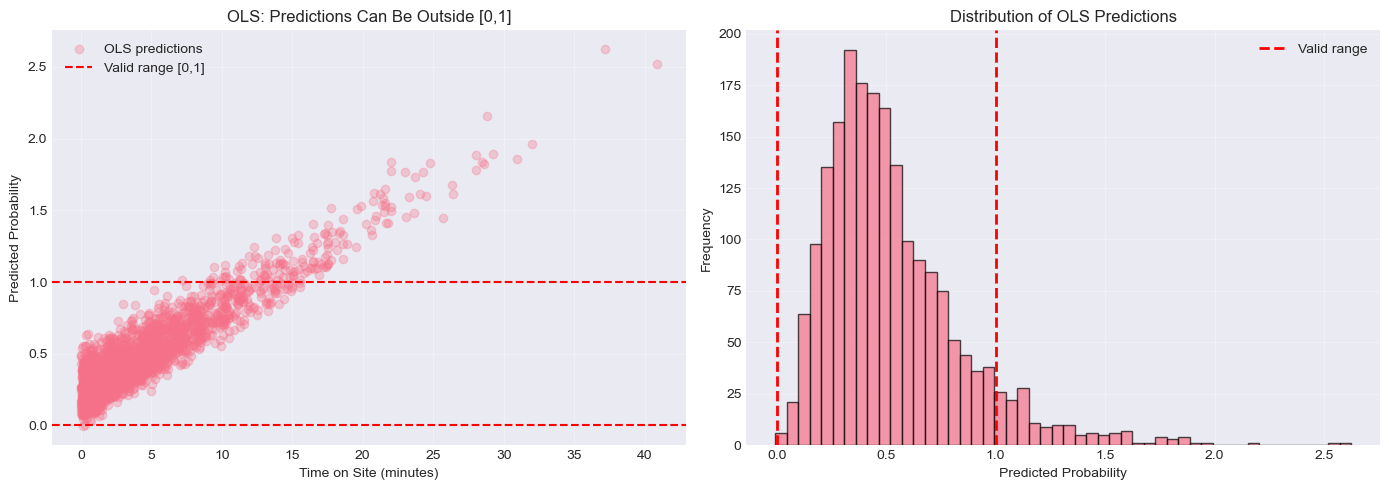

In [9]:
# Try OLS on binary outcome
X_ols = sm.add_constant(df_clicks[['time_on_site', 'previous_purchases', 'age', 'premium_member']])
ols_model = sm.OLS(df_clicks['clicked'], X_ols).fit()

# Predict probabilities
ols_pred = ols_model.predict(X_ols)

print("OLS Model Results:")
print(ols_model.summary().tables[1])
print(f"\nMinimum predicted value: {ols_pred.min():.4f}")
print(f"Maximum predicted value: {ols_pred.max():.4f}")
print(f"Predictions outside [0,1]: {((ols_pred < 0) | (ols_pred > 1)).sum()} out of {len(ols_pred)}")

# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted probabilities vs actual
axes[0].scatter(df_clicks['time_on_site'], ols_pred, alpha=0.3, label='OLS predictions')
axes[0].axhline(y=0, color='r', linestyle='--', label='Valid range [0,1]')
axes[0].axhline(y=1, color='r', linestyle='--')
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability')
axes[0].set_title('OLS: Predictions Can Be Outside [0,1]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of predictions
axes[1].hist(ols_pred, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Valid range')
axes[1].axvline(x=1, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of OLS Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/9v/zw_cmgf13nvgjmmlmmkbwd080000gn/T/ipykernel_76319/371672605.py:30: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


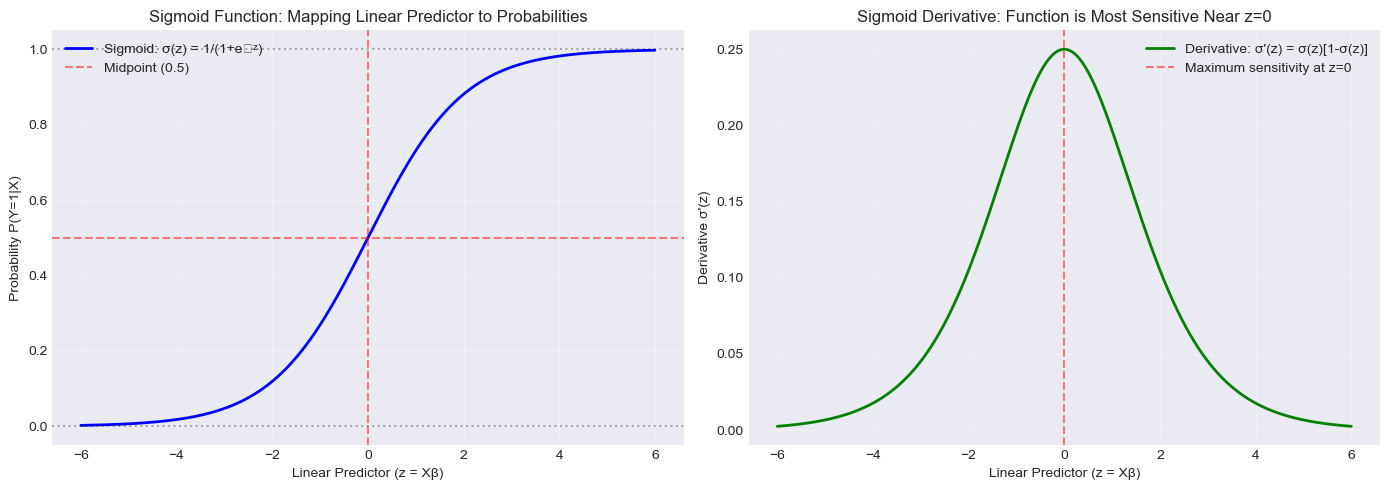

Key observations:
- Sigmoid maps any real number to (0,1)
- Steepest slope at z=0 (where probability = 0.5)
- Tails flatten out (probabilities near 0 or 1 are hard to change)


In [10]:
# Visualize the sigmoid function
z = np.linspace(-6, 6, 1000)
sigmoid = 1 / (1 + np.exp(-z))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sigmoid function
axes[0].plot(z, sigmoid, 'b-', linewidth=2, label='Sigmoid: σ(z) = 1/(1+e⁻ᶻ)')
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Midpoint (0.5)')
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].axhline(y=0, color='k', linestyle=':', alpha=0.3)
axes[0].axhline(y=1, color='k', linestyle=':', alpha=0.3)
axes[0].set_xlabel('Linear Predictor (z = Xβ)')
axes[0].set_ylabel('Probability P(Y=1|X)')
axes[0].set_title('Sigmoid Function: Mapping Linear Predictor to Probabilities')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# Plot 2: Derivative (showing where function is most sensitive)
sigmoid_derivative = sigmoid * (1 - sigmoid)
axes[1].plot(z, sigmoid_derivative, 'g-', linewidth=2, label="Derivative: σ'(z) = σ(z)[1-σ(z)]")
axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Maximum sensitivity at z=0')
axes[1].set_xlabel('Linear Predictor (z = Xβ)')
axes[1].set_ylabel("Derivative σ'(z)")
axes[1].set_title('Sigmoid Derivative: Function is Most Sensitive Near z=0')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("- Sigmoid maps any real number to (0,1)")
print("- Steepest slope at z=0 (where probability = 0.5)")
print("- Tails flatten out (probabilities near 0 or 1 are hard to change)")


### Logistic Regression (Logit Model)

The logit model applies the sigmoid function to a linear predictor:

$$P(Y=1|X) = \frac{1}{1 + e^{-X\beta}}$$

Or equivalently: $\log\left(\frac{p}{1-p}\right) = X\beta$ (log-odds = linear predictor)

**Key features:**
- Smooth and monotone
- Maps $(-\infty, \infty) \to (0,1)$
- Provides valid probabilities for all values of $X\beta$
- Coefficients are on the log-odds scale (need transformation for interpretation)


In [11]:
# Fit logistic regression
X_logit = sm.add_constant(df_clicks[['time_on_site', 'previous_purchases', 'age', 'premium_member']])
logit_model = Logit(df_clicks['clicked'], X_logit).fit()

print("Logistic Regression Results:")
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.322822
         Iterations 8
Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                  0.5331
Time:                        11:39:36   Log-Likelihood:                -645.64
converged:                       True   LL-Null:                       -1382.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.3642      0.315    -10.668      0.000 

### Decision Boundary

Binary outcome models estimate $P(Y=1|X)$. In many applications, we use probabilities to make binary decisions:

- Approve vs reject
- Treat vs do not treat  
- Classify as positive vs negative

**Decision rule:** Often we classify as $Y=1$ if $P(Y=1|X) \geq 0.5$

The set of covariate values where $P(Y=1|X) = 0.5$ defines the **decision boundary** in the feature space.

For logit: $P(Y=1|X) = 0.5$ when $X\beta = 0$ (since $\sigma(0) = 0.5$)


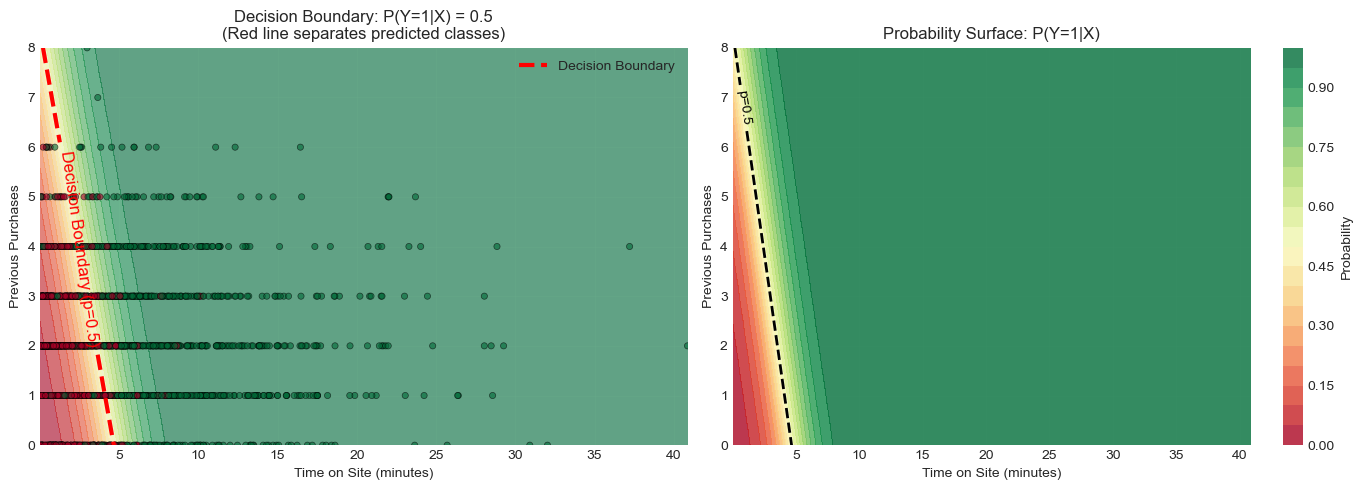

Key insight: The decision boundary is LINEAR (Xβ = 0), but the probability function is NONLINEAR (sigmoid)


In [12]:
# Visualize decision boundary
# For simplicity, use 2D: time_on_site vs previous_purchases
# Fix age and premium_member at their means for visualization
age_mean = df_clicks['age'].mean()
premium_mean = df_clicks['premium_member'].mean()

# Create grid for visualization
time_grid = np.linspace(df_clicks['time_on_site'].min(), df_clicks['time_on_site'].max(), 100)
purchases_grid = np.linspace(df_clicks['previous_purchases'].min(), df_clicks['previous_purchases'].max(), 100)
T, P = np.meshgrid(time_grid, purchases_grid)

# Calculate predicted probabilities on grid
X_grid = np.column_stack([
    np.ones(T.size),
    T.ravel(),
    P.ravel(),
    np.full(T.size, age_mean),
    np.full(T.size, premium_mean)
])
prob_grid = logit_model.predict(X_grid).reshape(T.shape)

# Plot decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Decision boundary contour
contour = axes[0].contour(T, P, prob_grid, levels=[0.5], colors='red', linewidths=3, linestyles='--')
axes[0].contourf(T, P, prob_grid, levels=20, cmap='RdYlGn', alpha=0.6)
axes[0].clabel(contour, inline=True, fontsize=12, fmt='Decision Boundary (p=0.5)')
scatter = axes[0].scatter(df_clicks['time_on_site'], df_clicks['previous_purchases'], 
                         c=df_clicks['clicked'], cmap='RdYlGn', s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Previous Purchases')
axes[0].set_title('Decision Boundary: P(Y=1|X) = 0.5\n(Red line separates predicted classes)')
axes[0].legend(handles=[plt.Line2D([0], [0], color='red', linestyle='--', linewidth=3, label='Decision Boundary')])
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability surface
im = axes[1].contourf(T, P, prob_grid, levels=20, cmap='RdYlGn', alpha=0.8)
contour2 = axes[1].contour(T, P, prob_grid, levels=[0.5], colors='black', linewidths=2, linestyles='--')
axes[1].clabel(contour2, inline=True, fontsize=10, fmt='p=0.5')
axes[1].set_xlabel('Time on Site (minutes)')
axes[1].set_ylabel('Previous Purchases')
axes[1].set_title('Probability Surface: P(Y=1|X)')
plt.colorbar(im, ax=axes[1], label='Probability')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: The decision boundary is LINEAR (Xβ = 0), but the probability function is NONLINEAR (sigmoid)")



Average Marginal Effects (Logit):
        Logit Marginal Effects       
Dep. Variable:                clicked
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
time_on_site           0.0923      0.001     65.827      0.000       0.090       0.095
previous_purchases     0.0516      0.005      9.868      0.000       0.041       0.062
age                   -0.0041      0.001     -5.657      0.000      -0.005      -0.003
premium_member         0.1810      0.014     12.578      0.000       0.153       0.209


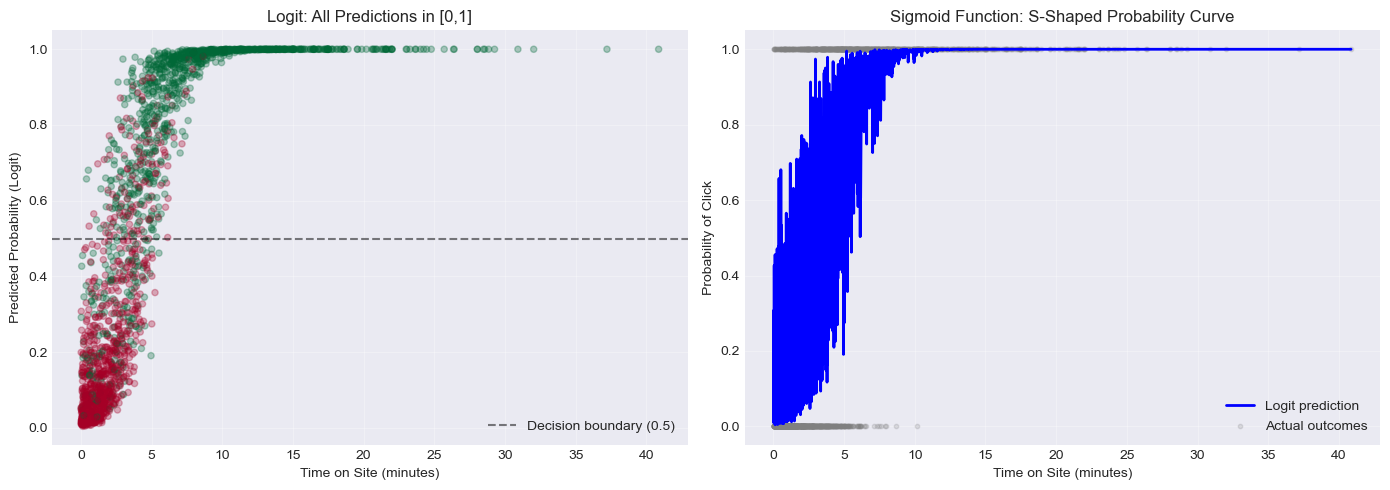


Logit predictions range: [0.0041, 1.0000]


In [13]:
# Get predicted probabilities from logit
logit_pred = logit_model.predict(X_logit)

# Calculate marginal effects (average marginal effects)
# For logit: ME = beta * p * (1-p)
marginal_effects = logit_model.get_margeff()
print("\nAverage Marginal Effects (Logit):")
print(marginal_effects.summary())

# Visualize logit predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted probabilities
axes[0].scatter(df_clicks['time_on_site'], logit_pred, alpha=0.3, c=df_clicks['clicked'], 
                cmap='RdYlGn', s=20)
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability (Logit)')
axes[0].set_title('Logit: All Predictions in [0,1]')
axes[0].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision boundary (0.5)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: S-shaped curve
sorted_idx = np.argsort(df_clicks['time_on_site'])
axes[1].plot(df_clicks['time_on_site'].values[sorted_idx], 
             logit_pred.values[sorted_idx], 'b-', linewidth=2, label='Logit prediction')
axes[1].scatter(df_clicks['time_on_site'], df_clicks['clicked'], 
                alpha=0.2, s=10, color='gray', label='Actual outcomes')
axes[1].set_xlabel('Time on Site (minutes)')
axes[1].set_ylabel('Probability of Click')
axes[1].set_title('Sigmoid Function: S-Shaped Probability Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLogit predictions range: [{logit_pred.min():.4f}, {logit_pred.max():.4f}]")


### Probit Regression

The probit model uses the standard normal CDF to map the linear predictor to probabilities:

$$P(Y=1|X) = \Phi(X\beta)$$

where $\Phi(\cdot)$ is the standard normal cumulative distribution function.

**Latent variable interpretation:** $Y^* = X\beta + \varepsilon$, where $\varepsilon \sim N(0,1)$, and $Y = 1$ if $Y^* > 0$.


In [14]:
# Fit probit regression
probit_model = Probit(df_clicks['clicked'], X_logit).fit()

print("Probit Regression Results:")
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.323487
         Iterations 8
Probit Regression Results:
                          Probit Regression Results                           
Dep. Variable:                clicked   No. Observations:                 2000
Model:                         Probit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                  0.5322
Time:                        11:39:36   Log-Likelihood:                -646.97
converged:                       True   LL-Null:                       -1382.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8975      0.174    -10.887      0.000   


Average Marginal Effects (Probit):
       Probit Marginal Effects       
Dep. Variable:                clicked
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
time_on_site           0.0923      0.001     66.203      0.000       0.090       0.095
previous_purchases     0.0504      0.005      9.554      0.000       0.040       0.061
age                   -0.0041      0.001     -5.621      0.000      -0.005      -0.003
premium_member         0.1824      0.014     12.632      0.000       0.154       0.211


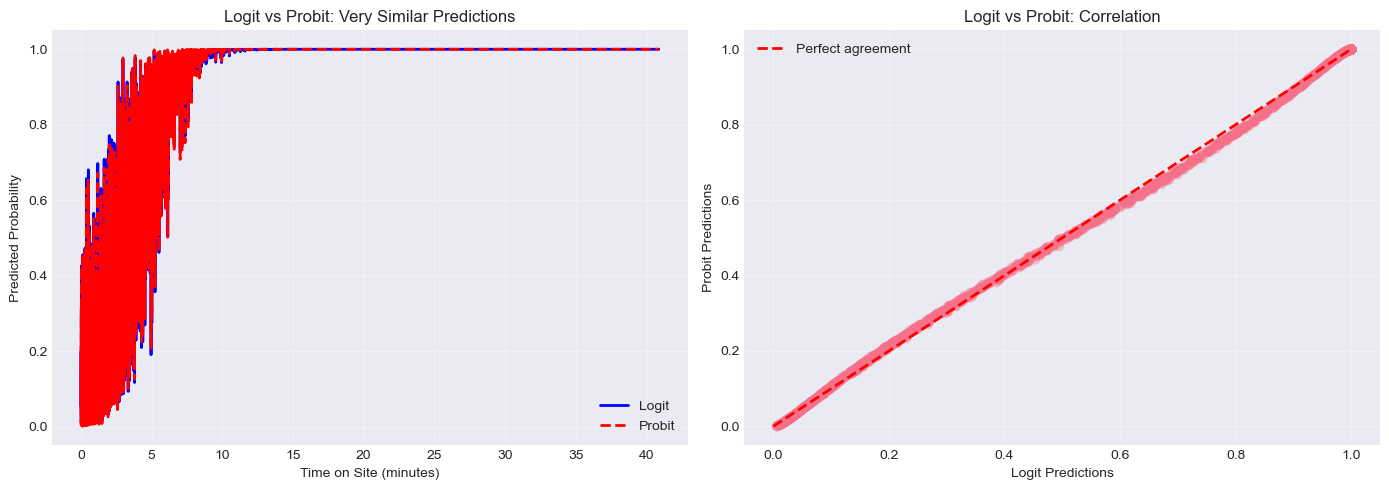


Correlation between logit and probit predictions: 0.9997


In [15]:
# Get predicted probabilities from probit
probit_pred = probit_model.predict(X_logit)

# Calculate marginal effects for probit
probit_marginal_effects = probit_model.get_margeff()
print("\nAverage Marginal Effects (Probit):")
print(probit_marginal_effects.summary())

# Compare logit and probit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Compare predictions
sorted_idx = np.argsort(df_clicks['time_on_site'])
axes[0].plot(df_clicks['time_on_site'].values[sorted_idx], 
             logit_pred.values[sorted_idx], 'b-', linewidth=2, label='Logit')
axes[0].plot(df_clicks['time_on_site'].values[sorted_idx], 
             probit_pred.values[sorted_idx], 'r--', linewidth=2, label='Probit')
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability')
axes[0].set_title('Logit vs Probit: Very Similar Predictions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter of logit vs probit predictions
axes[1].scatter(logit_pred, probit_pred, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect agreement')
axes[1].set_xlabel('Logit Predictions')
axes[1].set_ylabel('Probit Predictions')
axes[1].set_title('Logit vs Probit: Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between logit and probit predictions: {np.corrcoef(logit_pred, probit_pred)[0,1]:.4f}")


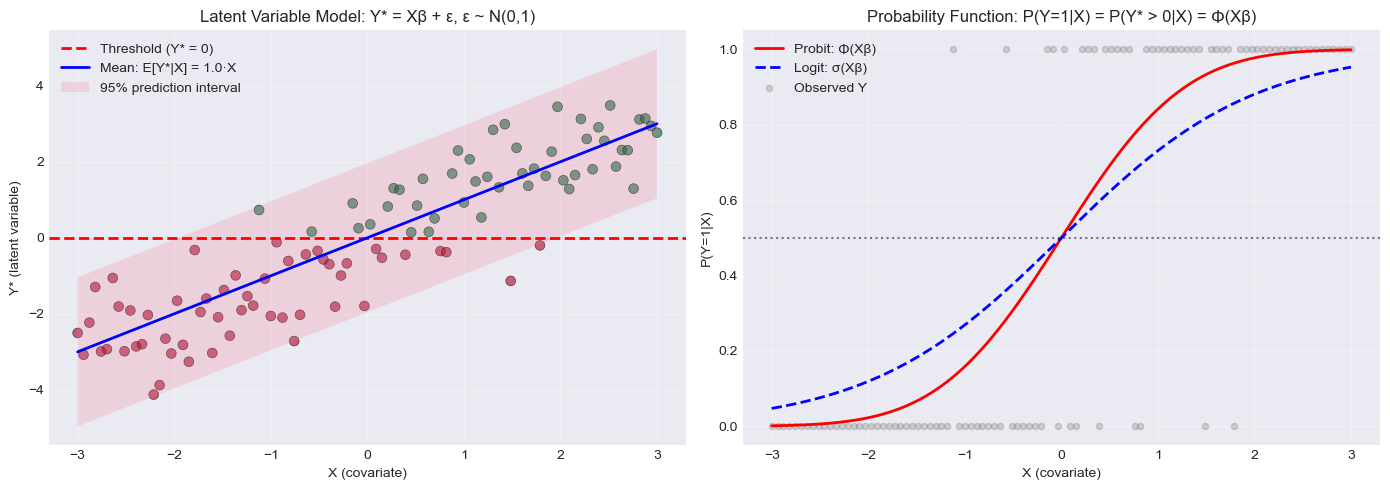

Key insight: We never observe Y*, but we can infer it from the probability that Y* > 0


In [16]:
# Visualize latent variable interpretation for probit
# Generate example to show latent variable concept
np.random.seed(42)
n_example = 100
x_example = np.linspace(-3, 3, n_example)
beta_example = 1.0
y_star_example = beta_example * x_example + np.random.normal(0, 1, n_example)
y_observed = (y_star_example > 0).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Latent variable Y* vs observed Y
axes[0].scatter(x_example, y_star_example, c=y_observed, cmap='RdYlGn', 
                s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Threshold (Y* = 0)')
axes[0].plot(x_example, beta_example * x_example, 'b-', linewidth=2, 
             label=f'Mean: E[Y*|X] = {beta_example:.1f}·X')
axes[0].fill_between(x_example, beta_example * x_example - 1.96, 
                      beta_example * x_example + 1.96, alpha=0.2, 
                      label='95% prediction interval')
axes[0].set_xlabel('X (covariate)')
axes[0].set_ylabel('Y* (latent variable)')
axes[0].set_title('Latent Variable Model: Y* = Xβ + ε, ε ~ N(0,1)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability as function of X
x_prob = np.linspace(-3, 3, 1000)
prob_probit = stats.norm.cdf(beta_example * x_prob)
prob_logit = 1 / (1 + np.exp(-beta_example * x_prob))

axes[1].plot(x_prob, prob_probit, 'r-', linewidth=2, label='Probit: Φ(Xβ)')
axes[1].plot(x_prob, prob_logit, 'b--', linewidth=2, label='Logit: σ(Xβ)')
axes[1].scatter(x_example, y_observed, alpha=0.3, s=20, color='gray', label='Observed Y')
axes[1].axhline(y=0.5, color='k', linestyle=':', alpha=0.5)
axes[1].set_xlabel('X (covariate)')
axes[1].set_ylabel('P(Y=1|X)')
axes[1].set_title('Probability Function: P(Y=1|X) = P(Y* > 0|X) = Φ(Xβ)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: We never observe Y*, but we can infer it from the probability that Y* > 0")


### Model Comparison: Logit vs Probit

**Key takeaways:**
- Both models produce very similar predictions
- Coefficients differ in scale (probit coefficients are typically smaller)
- Marginal effects are usually very similar
- Choice rarely changes substantive conclusions


### Understanding Marginal Effects

**Why we need marginal effects:** In logit and probit models, coefficients ($\beta$) are on the **latent scale** (log-odds for logit, latent variable scale for probit). They don't directly tell us how probabilities change, which is what we usually care about.

**Marginal Effect (ME):** The change in $P(Y=1|X)$ for a one-unit increase in $X_k$, holding other variables constant.

#### Formulas for Marginal Effects

**For Logit:**
$$\frac{\partial P(Y=1|X)}{\partial X_k} = \beta_k \cdot p(X) \cdot [1-p(X)]$$

where $p(X) = \frac{1}{1+e^{-X\beta}}$ is the predicted probability.

**For Probit:**
$$\frac{\partial P(Y=1|X)}{\partial X_k} = \beta_k \cdot \phi(X\beta)$$

where $\phi(\cdot)$ is the standard normal density function.

**Key insight:** Marginal effects depend on $X$! They vary across observations because:
- For logit: $p(X)[1-p(X)]$ is largest when $p(X) = 0.5$ and smallest when $p(X)$ is near 0 or 1
- For probit: $\phi(X\beta)$ is largest when $X\beta = 0$ (where probability = 0.5)

#### Average Marginal Effect (AME)

Since marginal effects vary by $X$, we typically report the **Average Marginal Effect (AME)**:

$$\text{AME}_k = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial P(Y=1|X_i)}{\partial X_k}$$

**Interpretation:** AME tells us the **average change in probability** across all observations in the sample.

**When to report AME:** Yes! Based on the slides, AME is the standard way to report marginal effects because:
1. It's on the probability scale (easy to interpret)
2. It's directly comparable between logit and probit
3. It gives a single summary measure for the effect of each variable

**Alternative measures:**
- **Marginal effect at the mean (MEM):** Evaluates ME at the mean of all covariates
- **Marginal effect at representative values (MER):** Evaluates ME at specific values of interest
- **AME is preferred** because it averages over the actual distribution of data


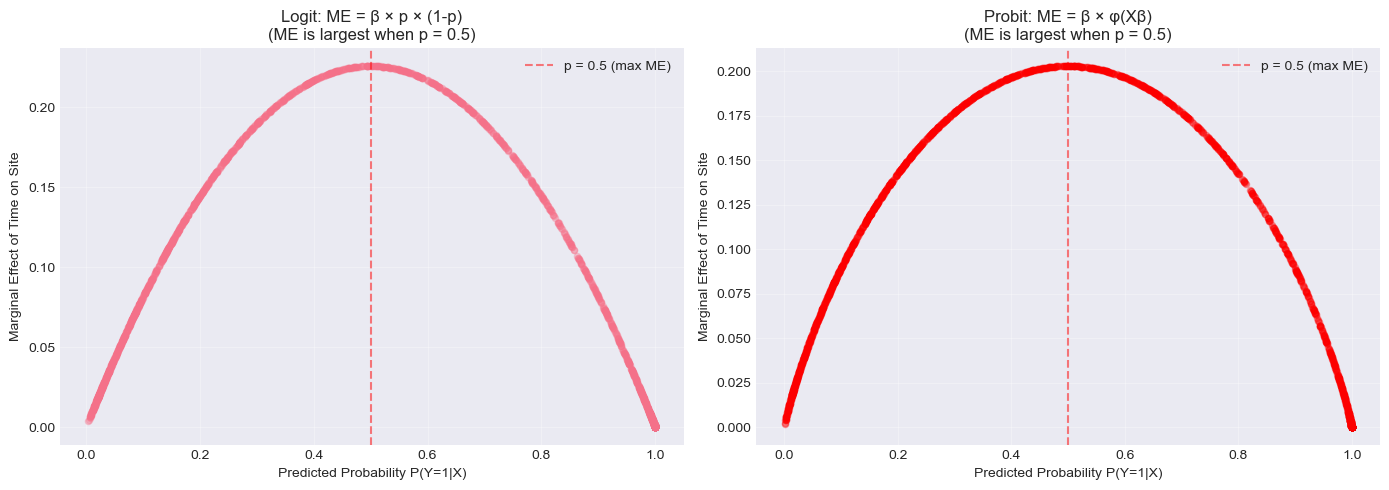

Marginal Effects for 'time_on_site' across observations:
  Logit - Individual MEs range: [0.0000, 0.2259]
  Logit - Average ME (AME): 0.0923
  Probit - Individual MEs range: [0.0000, 0.2031]
  Probit - Average ME (AME): 0.0923

Note: AME is what we report in the comparison table below.


In [24]:
# Demonstrate how marginal effects vary across observations
# Calculate marginal effects for each observation

# For logit: ME = beta * p * (1-p)
logit_me_time = logit_model.params['time_on_site'] * logit_pred * (1 - logit_pred)

# For probit: ME = beta * phi(X*beta)
# Need to calculate phi(X*beta) = standard normal density
from scipy.stats import norm
X_beta_probit = probit_model.fittedvalues  # This is X*beta for probit
phi_Xbeta = norm.pdf(X_beta_probit)
probit_me_time = probit_model.params['time_on_site'] * phi_Xbeta

# Visualize how marginal effects vary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: ME vs predicted probability (logit)
axes[0].scatter(logit_pred, logit_me_time, alpha=0.3, s=20)
axes[0].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='p = 0.5 (max ME)')
axes[0].set_xlabel('Predicted Probability P(Y=1|X)')
axes[0].set_ylabel('Marginal Effect of Time on Site')
axes[0].set_title('Logit: ME = β × p × (1-p)\n(ME is largest when p = 0.5)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: ME vs predicted probability (probit)
axes[1].scatter(probit_pred, probit_me_time, alpha=0.3, s=20, color='red')
axes[1].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='p = 0.5 (max ME)')
axes[1].set_xlabel('Predicted Probability P(Y=1|X)')
axes[1].set_ylabel('Marginal Effect of Time on Site')
axes[1].set_title('Probit: ME = β × φ(Xβ)\n(ME is largest when p = 0.5)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show AME vs individual MEs
print("Marginal Effects for 'time_on_site' across observations:")
print(f"  Logit - Individual MEs range: [{logit_me_time.min():.4f}, {logit_me_time.max():.4f}]")
print(f"  Logit - Average ME (AME): {logit_me_time.mean():.4f}")
print(f"  Probit - Individual MEs range: [{probit_me_time.min():.4f}, {probit_me_time.max():.4f}]")
print(f"  Probit - Average ME (AME): {probit_me_time.mean():.4f}")
print(f"\nNote: AME is what we report in the comparison table below.")


In [25]:
# Compare coefficients (note: probit coefficients are typically smaller)
# Exclude intercept from params to match marginal effects (which don't include intercept)
params_no_intercept = logit_model.params.drop('const')
probit_params_no_intercept = probit_model.params.drop('const')

comparison = pd.DataFrame({
    'Logit': params_no_intercept,
    'Probit': probit_params_no_intercept,
    'Logit_ME': marginal_effects.margeff,
    'Probit_ME': probit_marginal_effects.margeff
})
comparison['Ratio_Logit_Probit'] = comparison['Logit'] / comparison['Probit']

print("Coefficient Comparison (excluding intercept):")
print(comparison.round(4))

print("\n" + "="*80)
print("INTERPRETATION GUIDE:")
print("="*80)
print("\n1. Raw Coefficients (Logit/Probit columns):")
print("   - On latent scale (log-odds for logit, latent variable for probit)")
print("   - NOT directly interpretable on probability scale")
print("   - Probit coefficients are typically ~1.6-1.8x smaller than logit")
print("\n2. Average Marginal Effects (Logit_ME/Probit_ME columns):")
print("   - On PROBABILITY scale - these are what we report!")
print("   - Interpret as: 'A one-unit increase in X_k increases P(Y=1) by AME_k on average'")
print("   - Example: AME for time_on_site = 0.0923 means:")
print("     'One additional minute on site increases click probability by 9.23 percentage points, on average'")
print("\n3. Key Observation:")
print("   - While raw coefficients differ substantially (ratio ~1.75), AMEs are nearly identical")
print("   - This is why choice of logit vs probit rarely changes substantive conclusions")
print("\n4. What to Report:")
print("   ✓ Report AME (Average Marginal Effects) - as shown in Logit_ME/Probit_ME columns")
print("   ✗ Don't report raw coefficients for interpretation (they're on latent scale)")

# Compare model fit
print("\n" + "="*80)
print("Model Fit Comparison:")
print("="*80)
print(f"Logit Log-Likelihood: {logit_model.llf:.2f}")
print(f"Probit Log-Likelihood: {probit_model.llf:.2f}")
print(f"Logit AIC: {logit_model.aic:.2f}")
print(f"Probit AIC: {probit_model.aic:.2f}")


Coefficient Comparison (excluding intercept):
                     Logit  Probit  Logit_ME  Probit_ME  Ratio_Logit_Probit
time_on_site        0.9038  0.5090    0.0923     0.0923              1.7754
previous_purchases  0.5048  0.2780    0.0516     0.0504              1.8155
age                -0.0399 -0.0224   -0.0041    -0.0041              1.7779
premium_member      1.7720  1.0061    0.1810     0.1824              1.7612

INTERPRETATION GUIDE:

1. Raw Coefficients (Logit/Probit columns):
   - On latent scale (log-odds for logit, latent variable for probit)
   - NOT directly interpretable on probability scale
   - Probit coefficients are typically ~1.6-1.8x smaller than logit

2. Average Marginal Effects (Logit_ME/Probit_ME columns):
   - On PROBABILITY scale - these are what we report!
   - Interpret as: 'A one-unit increase in X_k increases P(Y=1) by AME_k on average'
   - Example: AME for time_on_site = 0.0923 means:
     'One additional minute on site increases click probability by

## Part 2: Count Outcomes - API Usage Prediction

**Scenario:** A cloud service provider wants to predict the number of API calls made by customers based on:
- Subscription tier (free, basic, premium)
- Number of active users
- Days since account creation
- Monthly subscription fee

This is a count outcome problem where:
- Outcomes are non-negative integers (0, 1, 2, ...)
- Variance increases with the mean
- OLS can produce negative predictions


In [18]:
# Generate synthetic data for Amazon transactions
n_count = 1500

# Generate covariates
prime_member = np.random.binomial(1, 0.4, n_count)  # 40% are Prime members
account_age_months = np.random.exponential(24, n_count).clip(1, 120)  # Months since registration
avg_order_value = np.random.lognormal(3.5, 0.8, n_count).clip(5, 500)  # Average order value in dollars
categories_browsed = np.random.poisson(3, n_count).clip(0, 15)  # Number of product categories

# True coefficients for Poisson (on log scale)
# Intercept set to give mean around 10, with right skew
# [intercept, prime_member, log(account_age), log(avg_order_value), categories_browsed]
beta_count_true = np.array([1.5, 0.6, 0.3, 0.4, 0.15])
X_count = np.column_stack([
    np.ones(n_count),
    prime_member,
    np.log(account_age_months + 1),  # Log transform for account age
    np.log(avg_order_value),  # Log transform for order value
    categories_browsed
])

# Generate count outcome using Poisson
# log(mu) = X*beta, so mu = exp(X*beta)
mu_true = np.exp(X_count @ beta_count_true)
y_count = np.random.poisson(mu_true)

# Create DataFrame
df_transactions = pd.DataFrame({
    'transactions': y_count,
    'prime_member': prime_member,
    'account_age_months': account_age_months,
    'avg_order_value': avg_order_value,
    'categories_browsed': categories_browsed
})

print("Amazon Transactions Dataset Summary:")
print(df_transactions.describe())
print(f"\nMean transactions: {df_transactions['transactions'].mean():.2f}")
print(f"Median transactions: {df_transactions['transactions'].median():.2f}")
print(f"Variance of transactions: {df_transactions['transactions'].var():.2f}")
print(f"Variance/Mean ratio: {df_transactions['transactions'].var() / df_transactions['transactions'].mean():.2f}")
print(f"Right skew: {df_transactions['transactions'].skew():.2f}")
print("(For Poisson, variance/mean should be close to 1)")


Amazon Transactions Dataset Summary:
       transactions  prime_member  account_age_months  avg_order_value  \
count   1500.000000   1500.000000         1500.000000      1500.000000   
mean      97.289333      0.407333           23.900776        45.761056   
std       61.260859      0.491502           23.184723        43.410371   
min       10.000000      0.000000            1.000000         5.000000   
25%       54.750000      0.000000            7.184039        18.722608   
50%       83.000000      0.000000           16.665019        32.997483   
75%      123.000000      1.000000           33.615430        56.425360   
max      580.000000      1.000000          120.000000       500.000000   

       categories_browsed  
count         1500.000000  
mean             2.932000  
std              1.624336  
min              0.000000  
25%              2.000000  
50%              3.000000  
75%              4.000000  
max             10.000000  

Mean transactions: 97.29
Median transaction

### Why OLS Fails for Count Data


OLS Model Results (Count Outcome):
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -28.8545      1.942    -14.859      0.000     -32.664     -25.045
prime_member          60.8148      1.464     41.536      0.000      57.943      63.687
account_age_months     1.1691      0.031     37.638      0.000       1.108       1.230
avg_order_value        0.6764      0.017     40.762      0.000       0.644       0.709
categories_browsed    14.4863      0.443     32.715      0.000      13.618      15.355

Minimum predicted value: -20.76
Maximum predicted value: 451.06
Negative predictions: 14 out of 1500
Percentage with negative predictions: 0.9%


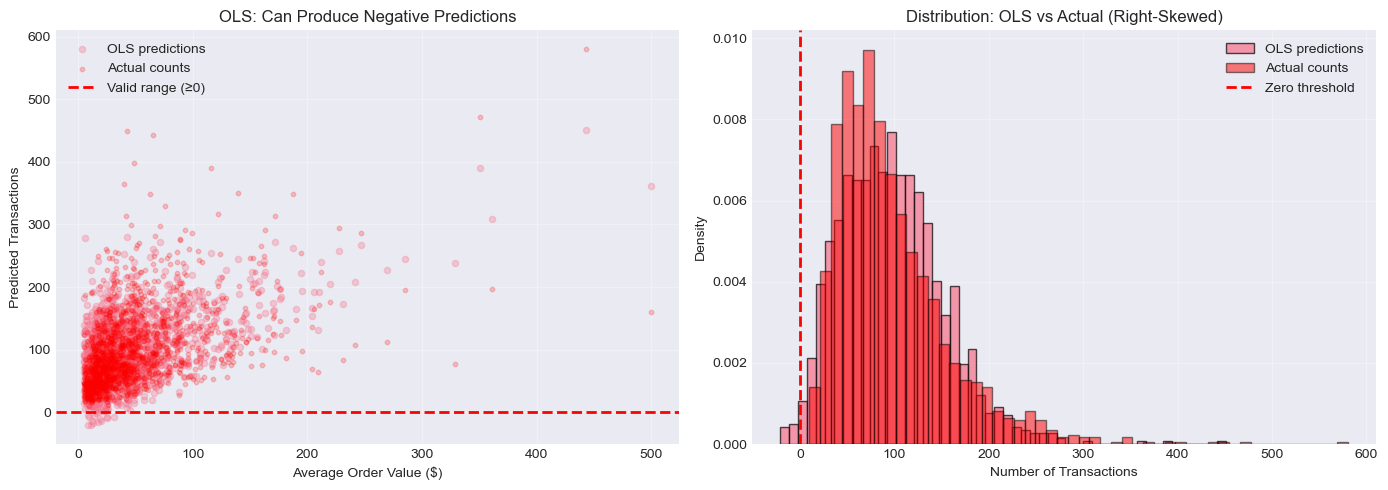

In [19]:
# Try OLS on count outcome
X_count_ols = sm.add_constant(df_transactions[['prime_member', 'account_age_months', 
                                                 'avg_order_value', 'categories_browsed']])
ols_count_model = sm.OLS(df_transactions['transactions'], X_count_ols).fit()

# Predict counts
ols_count_pred = ols_count_model.predict(X_count_ols)

print("OLS Model Results (Count Outcome):")
print(ols_count_model.summary().tables[1])
print(f"\nMinimum predicted value: {ols_count_pred.min():.2f}")
print(f"Maximum predicted value: {ols_count_pred.max():.2f}")
print(f"Negative predictions: {(ols_count_pred < 0).sum()} out of {len(ols_count_pred)}")
print(f"Percentage with negative predictions: {(ols_count_pred < 0).sum() / len(ols_count_pred) * 100:.1f}%")

# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs actual
axes[0].scatter(df_transactions['avg_order_value'], ols_count_pred, alpha=0.3, label='OLS predictions', s=20)
axes[0].scatter(df_transactions['avg_order_value'], df_transactions['transactions'], alpha=0.2, 
                color='red', s=10, label='Actual counts')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Valid range (≥0)')
axes[0].set_xlabel('Average Order Value ($)')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('OLS: Can Produce Negative Predictions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of predictions
axes[1].hist(ols_count_pred, bins=50, edgecolor='black', alpha=0.7, label='OLS predictions', density=True)
axes[1].hist(df_transactions['transactions'], bins=50, edgecolor='black', alpha=0.5, 
             color='red', label='Actual counts', density=True)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero threshold')
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution: OLS vs Actual (Right-Skewed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Poisson Regression

Poisson regression models count outcomes using:

- **Distribution:** $Y|X \sim \text{Poisson}(\mu)$
- **Link function:** $\log(\mu) = X\beta$ (canonical log link)
- **Properties:** $E[Y|X] = \mu$, $\text{Var}(Y|X) = \mu$

**Interpretation:** Coefficients are on the log-count scale. A one-unit increase in $X_k$ multiplies the expected count by $e^{\beta_k}$.


In [20]:
# Prepare data for Poisson regression
X_poisson = sm.add_constant(pd.DataFrame({
    'prime_member': df_transactions['prime_member'],
    'log_account_age': np.log(df_transactions['account_age_months'] + 1),
    'log_avg_order_value': np.log(df_transactions['avg_order_value']),
    'categories_browsed': df_transactions['categories_browsed']
}))

# Fit Poisson regression
poisson_model = GLM(df_transactions['transactions'], X_poisson, family=families.Poisson()).fit()

print("Poisson Regression Results:")
print(poisson_model.summary())


Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           transactions   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5476.1
Date:                Tue, 06 Jan 2026   Deviance:                       1587.6
Time:                        11:39:37   Pearson chi2:                 1.58e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const 


Coefficient Interpretation:
Intercept: 1.4964
Prime Member: 0.6034 (exp(0.6034) = 1.8282, +82.82% change per unit)
Log(Account Age): 0.3003 (exp(0.3003) = 1.3503, +35.03% change per unit)
Log(Avg Order Value): 0.4019 (exp(0.4019) = 1.4947, +49.47% change per unit)
Categories Browsed: 0.1479 (exp(0.1479) = 1.1594, +15.94% change per unit)


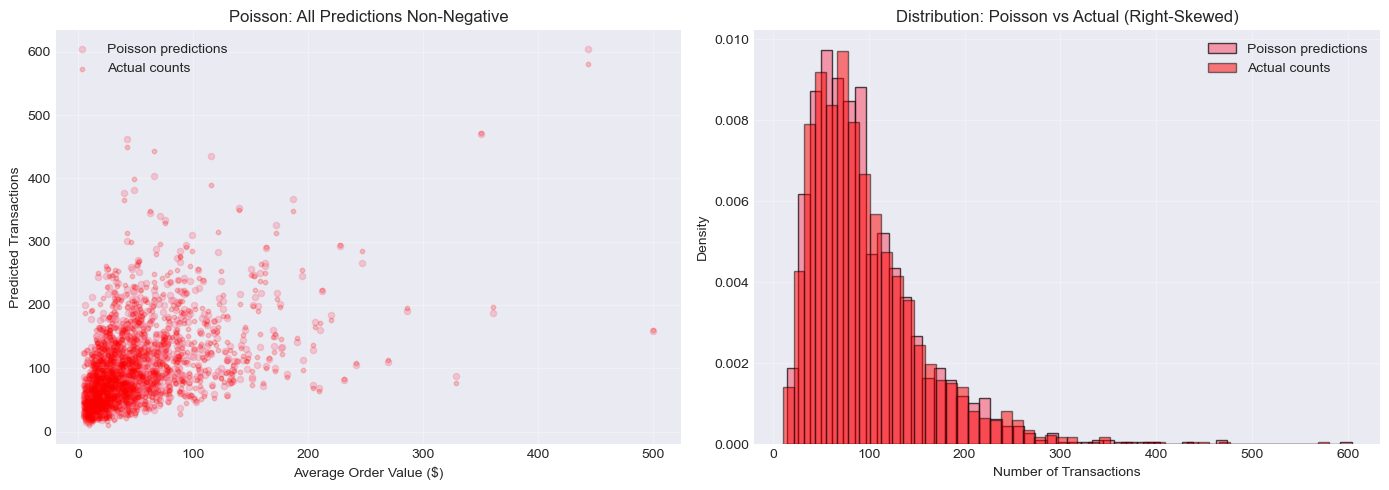


Poisson predictions range: [14.55, 603.91]
Negative predictions: 0


In [21]:
# Get predicted counts
poisson_pred = poisson_model.predict(X_poisson)

# Interpret coefficients
print("\nCoefficient Interpretation:")
print("=" * 60)
coef_names = ['Intercept', 'Prime Member', 'Log(Account Age)', 
              'Log(Avg Order Value)', 'Categories Browsed']
for i, (name, coef) in enumerate(zip(coef_names, poisson_model.params)):
    if i == 0:
        print(f"{name}: {coef:.4f}")
    else:
        pct_change = (np.exp(coef) - 1) * 100
        print(f"{name}: {coef:.4f} (exp({coef:.4f}) = {np.exp(coef):.4f}, "
              f"{pct_change:+.2f}% change per unit)")

# Visualize Poisson model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs actual
axes[0].scatter(df_transactions['avg_order_value'], poisson_pred, alpha=0.3, 
                label='Poisson predictions', s=20)
axes[0].scatter(df_transactions['avg_order_value'], df_transactions['transactions'], alpha=0.2, 
                color='red', s=10, label='Actual counts')
axes[0].set_xlabel('Average Order Value ($)')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('Poisson: All Predictions Non-Negative')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution comparison
axes[1].hist(poisson_pred, bins=50, edgecolor='black', alpha=0.7, 
             label='Poisson predictions', density=True)
axes[1].hist(df_transactions['transactions'], bins=50, edgecolor='black', alpha=0.5, 
             color='red', label='Actual counts', density=True)
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution: Poisson vs Actual (Right-Skewed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPoisson predictions range: [{poisson_pred.min():.2f}, {poisson_pred.max():.2f}]")
print(f"Negative predictions: {(poisson_pred < 0).sum()}")


### Model Comparison: OLS vs Poisson

**Key differences:**
- OLS can produce negative predictions (invalid for counts)
- Poisson ensures non-negative predictions
- Poisson accounts for mean-variance relationship
- Poisson coefficients have multiplicative interpretation


Model Comparison:
OLS - Negative predictions: 14
Poisson - Negative predictions: 0

OLS - Mean Absolute Error: 19.34
Poisson - Mean Absolute Error: 7.77

OLS - R-squared: 0.7941
Poisson - McFadden's Pseudo R-squared: 0.8152
  (Note: Cox-Snell pseudo R² = 1.0000 can be misleadingly high with synthetic data)


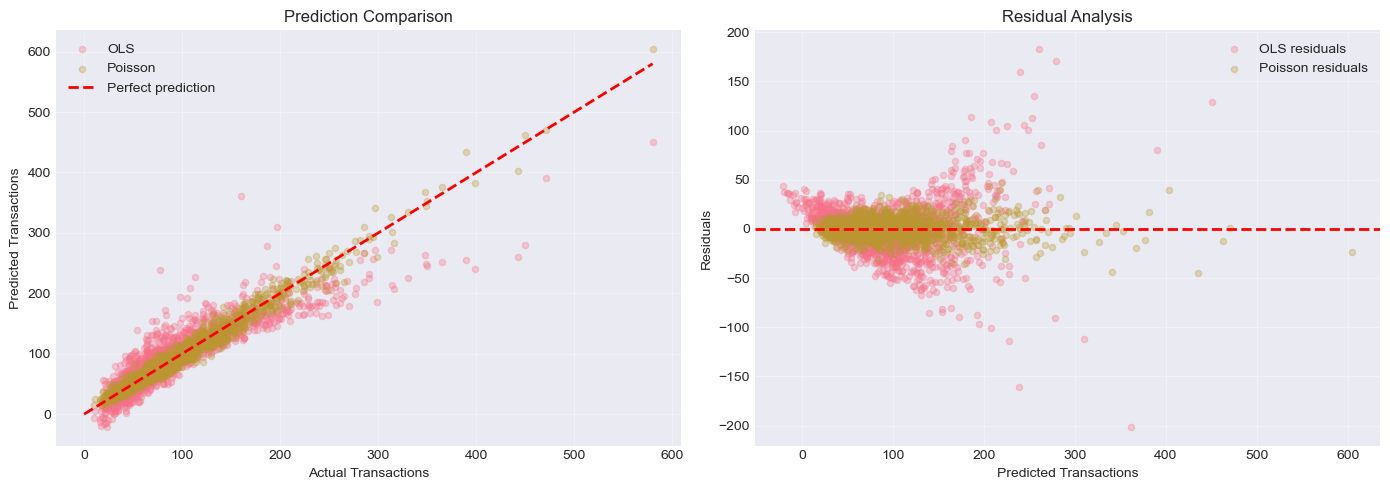

In [22]:
# Compare model performance
comparison_count = pd.DataFrame({
    'Actual': df_transactions['transactions'],
    'OLS': ols_count_pred,
    'Poisson': poisson_pred
})

# Calculate metrics
print("Model Comparison:")
print("=" * 60)
print(f"OLS - Negative predictions: {(ols_count_pred < 0).sum()}")
print(f"Poisson - Negative predictions: {(poisson_pred < 0).sum()}")
print(f"\nOLS - Mean Absolute Error: {np.mean(np.abs(df_transactions['transactions'] - ols_count_pred)):.2f}")
print(f"Poisson - Mean Absolute Error: {np.mean(np.abs(df_transactions['transactions'] - poisson_pred)):.2f}")
print(f"\nOLS - R-squared: {ols_count_model.rsquared:.4f}")

# Calculate McFadden's pseudo R-squared (more standard than Cox-Snell)
# McFadden's: 1 - (LL_model / LL_null)
# First fit a null model (intercept only)
null_model = GLM(df_transactions['transactions'], 
                 sm.add_constant(np.ones(len(df_transactions))), 
                 family=families.Poisson()).fit()
ll_model = poisson_model.llf
ll_null = null_model.llf
mcfadden_rsq = 1 - (ll_model / ll_null) if ll_null != 0 else 0
print(f"Poisson - McFadden's Pseudo R-squared: {mcfadden_rsq:.4f}")
print(f"  (Note: Cox-Snell pseudo R² = {poisson_model.pseudo_rsquared():.4f} can be misleadingly high with synthetic data)")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions comparison
axes[0].scatter(df_transactions['transactions'], ols_count_pred, alpha=0.3, label='OLS', s=20)
axes[0].scatter(df_transactions['transactions'], poisson_pred, alpha=0.3, label='Poisson', s=20)
axes[0].plot([0, df_transactions['transactions'].max()], [0, df_transactions['transactions'].max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Transactions')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('Prediction Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
ols_residuals = df_transactions['transactions'] - ols_count_pred
poisson_residuals = df_transactions['transactions'] - poisson_pred

axes[1].scatter(ols_count_pred, ols_residuals, alpha=0.3, label='OLS residuals', s=20)
axes[1].scatter(poisson_pred, poisson_residuals, alpha=0.3, label='Poisson residuals', s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Transactions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: Preview - Categorical Outcomes

So far we've covered:
- **Binary outcomes** → Logit / Probit
- **Count outcomes** → Poisson

Another common case: **Categorical outcomes** $Y \in \{1, 2, ..., J\}$

### Types of Categorical Outcomes

1. **Unordered categories** (no natural ranking)
   - Examples: Transportation mode (car / bus / train), Brand choice, Occupation
   - Model: **Multinomial logit/probit**

2. **Ordered categories** (natural ranking, unknown spacing)
   - Examples: Education level, Credit rating, Likert-scale responses
   - Model: **Ordered logit/probit**

### Multinomial Logit (Preview)

For unordered categories, the multinomial logit models the probability of choosing alternative $j$:

$$P(Y = j | X) = \frac{\exp(X\beta_j)}{\sum_{k=1}^{J} \exp(X\beta_k)}$$

**Key features:**
- One coefficient vector $\beta_j$ per alternative
- Probabilities sum to 1 across all alternatives
- Must choose a baseline category (normalize one $\beta$ to zero)
- Extends binary logit to multiple unordered choices

### Ordered Logit/Probit (Preview)

For ordered categories, ordered models rely on the **parallel regression (proportional odds) assumption**:

- Covariate effects are the same across all outcome thresholds
- Differences between categories are captured by intercepts (cutpoints)
- Single $\beta$ vector, multiple thresholds

**Note:** These models will be covered in more detail in future lessons. The key takeaway is that GLM principles apply: choose the distribution that matches your outcome structure, use appropriate link functions, and estimate via MLE.


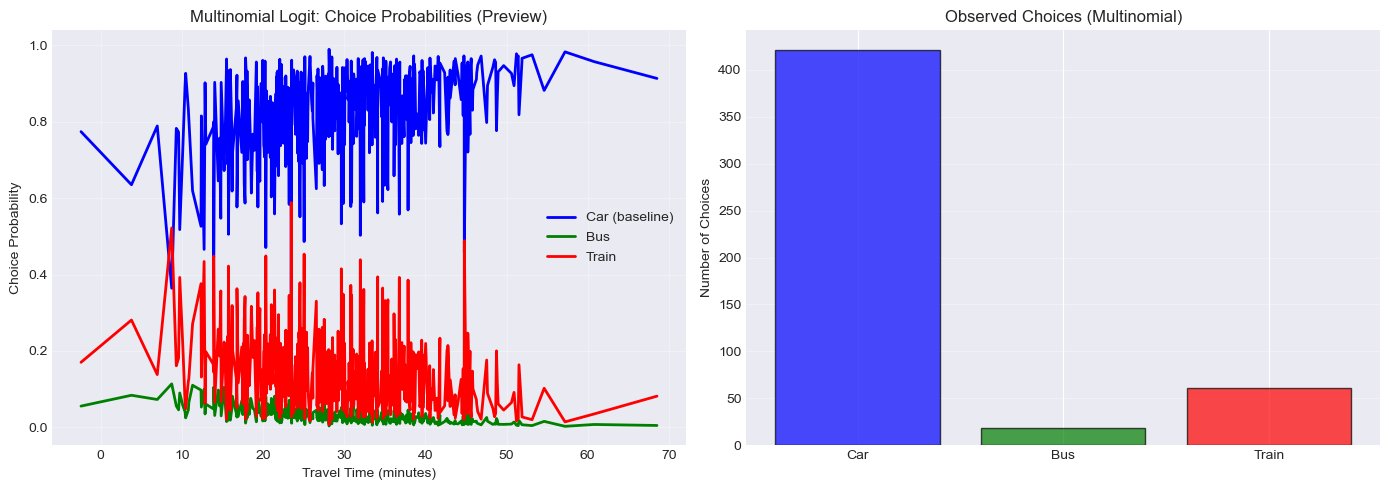

Key insight: Multinomial logit extends binary logit to multiple unordered choices
All probabilities sum to 1, and one category serves as the baseline


In [23]:
# Brief conceptual example: Multinomial logit
# (Full implementation would require more setup - this is just a preview)

from scipy.special import softmax

# Simulate a simple multinomial choice scenario
# 3 transportation modes: Car (0), Bus (1), Train (2)
# Based on: travel time, cost, convenience score

np.random.seed(42)
n_categorical = 500
travel_time = np.random.normal(30, 10, n_categorical)  # minutes
cost = np.random.normal(5, 2, n_categorical)  # dollars
convenience = np.random.normal(0, 1, n_categorical)  # standardized

# True coefficients (Car is baseline, so beta_car = 0)
# For Bus: [intercept, time, cost, convenience]
beta_bus = np.array([-1.0, -0.05, -0.2, 0.5])
# For Train: [intercept, time, cost, convenience]  
beta_train = np.array([-0.5, -0.03, -0.15, 0.8])

X_cat = np.column_stack([np.ones(n_categorical), travel_time, cost, convenience])

# Calculate probabilities using multinomial logit
# P(Y=j|X) = exp(X*beta_j) / sum_k exp(X*beta_k)
logits_car = np.zeros(n_categorical)  # Baseline
logits_bus = X_cat @ beta_bus
logits_train = X_cat @ beta_train

logits_matrix = np.column_stack([logits_car, logits_bus, logits_train])
probs_matrix = softmax(logits_matrix, axis=1)

# Generate choices based on probabilities
choices = np.array([np.random.choice(3, p=probs_matrix[i]) for i in range(n_categorical)])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Choice probabilities as function of travel time
time_sorted_idx = np.argsort(travel_time)
axes[0].plot(travel_time[time_sorted_idx], probs_matrix[time_sorted_idx, 0], 
             'b-', linewidth=2, label='Car (baseline)')
axes[0].plot(travel_time[time_sorted_idx], probs_matrix[time_sorted_idx, 1], 
             'g-', linewidth=2, label='Bus')
axes[0].plot(travel_time[time_sorted_idx], probs_matrix[time_sorted_idx, 2], 
             'r-', linewidth=2, label='Train')
axes[0].set_xlabel('Travel Time (minutes)')
axes[0].set_ylabel('Choice Probability')
axes[0].set_title('Multinomial Logit: Choice Probabilities (Preview)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Actual choices
choice_counts = pd.Series(choices).value_counts().sort_index()
axes[1].bar(['Car', 'Bus', 'Train'], choice_counts.values, 
            color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Choices')
axes[1].set_title('Observed Choices (Multinomial)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key insight: Multinomial logit extends binary logit to multiple unordered choices")
print("All probabilities sum to 1, and one category serves as the baseline")


## Summary: GLM Framework

This notebook demonstrated the GLM framework with tech company examples:

### Key Takeaways:

1. **Binary Outcomes (Logit/Probit):**
   - OLS fails because predictions can be outside [0,1]
   - Logit and probit use nonlinear link functions to ensure valid probabilities
   - Both models produce very similar results
   - Coefficients need to be interpreted via marginal effects or odds ratios

2. **Count Outcomes (Poisson):**
   - OLS fails because predictions can be negative
   - Poisson regression uses log link to ensure non-negative predictions
   - Coefficients have multiplicative interpretation
   - Accounts for mean-variance relationship

3. **GLM Structure:**
   - All GLMs share: Linear predictor $\eta = X\beta$
   - They differ in: Distribution + Link function
   - Estimation via maximum likelihood

### When to Use Each Model:

| Outcome Type | Model | Example |
|-------------|-------|---------|
| Continuous | OLS | Revenue, prices |
| Binary | Logit/Probit | Click, purchase, default |
| Count | Poisson | API calls, visits, patents |
| Ordered categories | Ordered logit/probit | Rating scales, education levels |
| Unordered categories | Multinomial logit | Brand choice, transportation mode |

**Remember:** Choose the model based on the outcome distribution, not just convenience!


## References

- ECON 5140: Applied Econometrics, Lesson 1 - Generalized Linear Models
- Statsmodels documentation: https://www.statsmodels.org/
- Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data*
- Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*
